# Laplacian experiment

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from network import LPN
from utils import prox, cvx, prior, gt_cvx, soft_thr

sns.set()

MODEL_DIR = "experiments/models/"
os.makedirs(MODEL_DIR, exist_ok=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set seed
np.random.seed(1)
torch.manual_seed(1)

## Define distribution

In [2]:
dim = 1

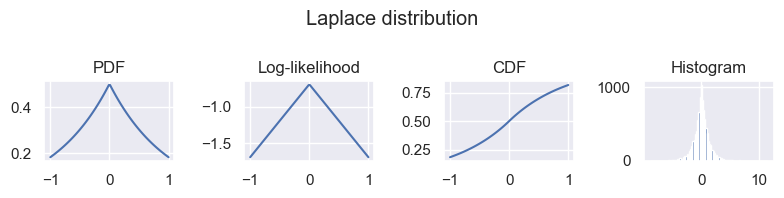

In [3]:
# Sample data points from Laplacian distribution:
# exp(-|x|/b) / (2b)
def sample_laplace(n, b):
    """
    Inputs:
        n: number of points
        b: scale parameter of the Laplacian distribution
    Outputs:
        x: a vector of n points, torch.tensor
    """
    x = torch.distributions.laplace.Laplace(0, b).sample((n,))
    return x


class LaplaceSampler(object):
    def __init__(self, b):
        self.b = b

    def __call__(self, n):
        return sample_laplace(n, self.b)


b = 1.0
dist = torch.distributions.laplace.Laplace(0, b)
x = LaplaceSampler(b)(10000)
# plot pdf, log-likelihood, cdf
plt.rcParams["figure.figsize"] = (8, 2)
x = torch.linspace(-1, 1, 100)
plt.subplot(1, 4, 1)
plt.plot(x, dist.log_prob(x).exp())
plt.title("PDF")
plt.subplot(1, 4, 2)
plt.plot(x, dist.log_prob(x))
plt.title("Log-likelihood")
plt.subplot(1, 4, 3)
plt.plot(x, dist.cdf(x))
plt.title("CDF")
plt.subplot(1, 4, 4)
plt.hist(sample_laplace(10000, b), bins=100)
plt.title("Histogram")
plt.suptitle("Laplace distribution")
plt.tight_layout()

In [4]:
# Add noise to the data
def add_noise(x, sigma=0.1):
    """
    Inputs:
        x: a vector of n points, torch.tensor
        sigma: standard deviation of the noise
    Outputs:
        x: a vector of n points, torch.tensor
    """
    noise = torch.randn_like(x) * sigma
    return x + noise

In [5]:
# parameters for laplace distribution
b = 1
sigma_noise = 0.0
sampler = LaplaceSampler(b)

Text(0.5, 1.0, 'Example training points')

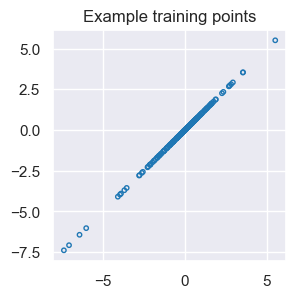

In [6]:
# example training points
target = sampler(200).unsqueeze(1)
input = add_noise(target, sigma_noise)
plt.rcParams["figure.figsize"] = (3, 3)
plt.scatter(input, target, s=10, facecolors="none", edgecolors="tab:blue")
plt.grid("on")
plt.title("Example training points")

### Plot function

In [7]:
# function to plot learned prox, convex function, original function
def plot_all(model):
    xi = np.linspace(-4, 4, 1000)

    y = prox(xi, model)
    c = cvx(xi, model)
    p = prior(xi, model)

    plt.rcParams["figure.figsize"] = (8, 3)

    # learned prox
    plt.subplot(1, 3, 1)
    plt.plot(xi, y, "-", ms=5, label="LPN")
    plt.plot(xi, soft_thr(xi), "--", label="soft thr.", zorder=1.9)
    plt.grid("on")
    plt.legend()
    plt.title("Learned prox")

    # convex function
    plt.subplot(1, 3, 2)
    plt.plot(xi, c - c.min(), "-", ms=5, label="Cvx func")
    plt.plot(xi, gt_cvx(xi), "--", label="ref.", zorder=1.9)
    plt.grid("on")
    plt.legend()
    plt.title("Cvx func")

    # original function
    plt.subplot(1, 3, 3)
    plt.plot(xi, p - p.min(), label="LPN")
    plt.plot(xi, np.abs(xi), "--", label=r"$\ell_1$", zorder=1.9)
    plt.grid("on")
    plt.legend()
    plt.title("Original func")

    plt.tight_layout()

## Define loss

Text(0.5, 1.0, 'exp loss')

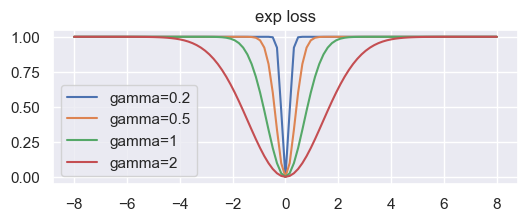

In [8]:
# proximal matching loss: -exp(-(x/gamma)^2) + 1
def exp_func(x, gamma):
    return -torch.exp(-((x / gamma) ** 2)) + 1


# visualize the loss at different sigma
plt.rcParams["figure.figsize"] = (6, 2)
x = torch.linspace(-8, 8, 101)
for gamma_exp_loss in [0.2, 0.5, 1, 2]:
    plt.plot(x, exp_func(x, gamma_exp_loss), label="gamma=" + str(gamma_exp_loss))
plt.legend()
plt.grid("on")
plt.title("exp loss")

## Model parameters

In [9]:
beta = 10  # beta of softplus
hidden = 50  # number of hidden units
layers = 4  # number of layers

# create a model
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
print(
    "Number of parameters in ICNN",
    sum(p.size().numel() for p in lpn_model.parameters()),
)

Number of parameters in ICNN 10502


## Training function

In [10]:
def single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss=None):
    target = sampler(bsize).unsqueeze(1)
    input = add_noise(target, sigma_noise)
    
    input, target = input.to(device), target.to(device)
    out = lpn_model(input)

    if loss_type == 2:
        loss = (out - target).pow(2).sum() / bsize  # MSE loss
    elif loss_type == 1:
        loss = (out - target).abs().sum() / bsize  # MAE loss
    elif loss_type == 0:
        loss = exp_func(out - target, gamma_loss).mean()  # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss

iteration 0 loss 1.6968586444854736
iteration 0 loss 11.847487449645996
iteration 500 loss 0.4049803614616394
iteration 1000 loss 0.2799735963344574
iteration 1500 loss 0.2277785986661911
iteration 2000 loss 0.17106911540031433
iteration 2500 loss 0.0985715463757515
iteration 3000 loss 0.029364367946982384
iteration 3500 loss 0.02155599184334278
iteration 4000 loss 0.02245359495282173
iteration 4500 loss 0.006130279041826725
iteration 5000 loss 0.003408219898119569
iteration 5500 loss 0.0031330701895058155
iteration 6000 loss 0.0028633957263082266
iteration 6500 loss 0.0001563419064041227
iteration 7000 loss 0.0015606135129928589
iteration 7500 loss 7.76453161961399e-05
iteration 8000 loss 0.0002593139070086181
iteration 8500 loss 7.545262633357197e-05
iteration 9000 loss 3.393632505321875e-05
iteration 9500 loss 3.086437936872244e-05
mse 5.344010829925537
mse 2.445525884628296
mse 1.034848690032959
mse 0.41291913390159607
mse 0.14834833145141602
mse 0.05028477683663368
mse 0.013306860

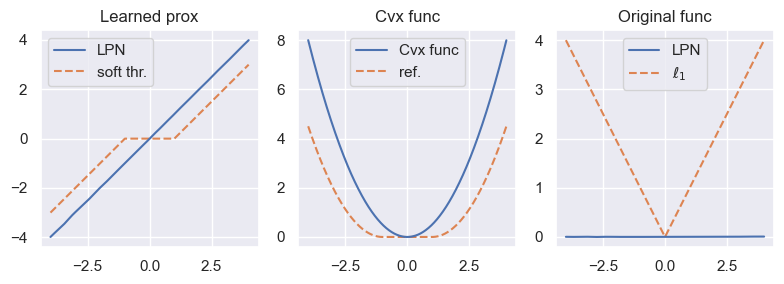

In [11]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)
bsize = 2000

for i in range(1):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(10000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

plot_all(lpn_model)
print(
    "Values at [-3,-2,-1,0,1,2,3]:",
    lpn_model(
        torch.tensor([-3, -2, -1, 0, 1, 2, 3]).unsqueeze(1).float().to(device)
    ).squeeze(1),
)

L1 loss

iteration 0 loss 1.2233543395996094
iteration 500 loss 0.01879749819636345
iteration 1000 loss 0.010855216532945633
iteration 1500 loss 0.02717759646475315
iteration 2000 loss 0.009603067301213741
iteration 2500 loss 0.018801432102918625
iteration 3000 loss 0.012639307416975498
iteration 3500 loss 0.017957452684640884
iteration 4000 loss 0.008453531190752983
iteration 4500 loss 0.008230604231357574
iteration 5000 loss 0.006146601866930723
iteration 5500 loss 0.011557427234947681
iteration 6000 loss 0.007105288561433554
iteration 6500 loss 0.008122880011796951
iteration 7000 loss 0.010663590393960476
iteration 7500 loss 0.009511678479611874
iteration 8000 loss 0.012912269681692123
iteration 8500 loss 0.009872312657535076
iteration 9000 loss 0.006277354899793863
iteration 9500 loss 0.010445525869727135
iteration 0 loss 0.0034062666818499565
iteration 500 loss 0.0004980113008059561
iteration 1000 loss 0.0009671280859038234
iteration 1500 loss 0.000630750902928412
iteration 2000 loss 0.001

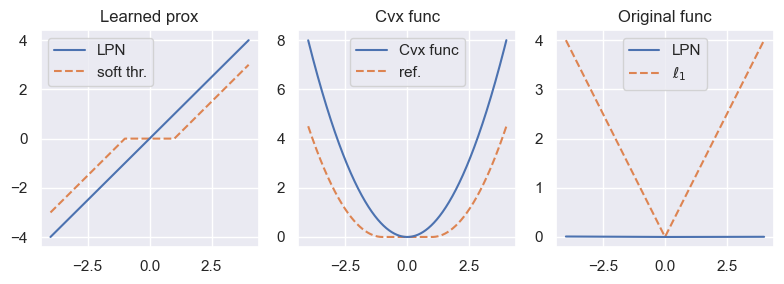

In [12]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)
bsize = 2000

for i in range(10000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type=1)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(10000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type=1)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l1.pth"))

plot_all(lpn_model)
print(
    "Values at [-3,-2,-1,0,1,2,3]:",
    lpn_model(
        torch.tensor([-3, -2, -1, 0, 1, 2, 3]).unsqueeze(1).float().to(device)
    ).squeeze(1),
)

## Proximal matching loss

gamma=0.5

iteration 0 loss 1.1296898264845368e-05
iteration 500 loss 2.8790742362616584e-05
iteration 1000 loss 1.7307072994299233e-05
iteration 1500 loss 5.215489727561362e-05
iteration 0 loss 7.241415733005852e-05
iteration 500 loss 0.00012610437988769263
iteration 1000 loss 9.51498714130139e-06
iteration 1500 loss 3.1441747978533385e-06
mse 5.344010829925537
mse 2.420905351638794
mse 1.0298571586608887
mse 0.4047906696796417
mse 0.14522460103034973
mse 0.047106508165597916
mse 0.013708371669054031
mse 0.003566018771380186
mse 0.0008234655833803117
mse 0.00016824271006044
final mse 3.07596055790782e-05
(1000,) (1000,) (1000,) (1000,)


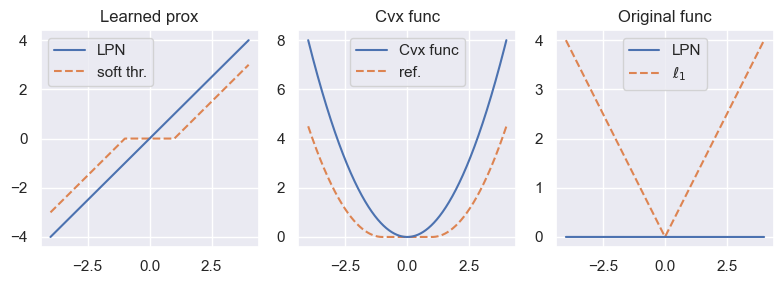

In [13]:
loss_type = 0
gamma_loss = 0.5

# set learning rate
for g in optimizer.param_groups:
    g["lr"] = 1e-3

for i in range(2000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

for g in optimizer.param_groups:
    g["lr"] = 1e-4

for i in range(2000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)

gamma=0.4

iteration 0 loss 1.787245309969876e-06
iteration 500 loss 1.3755053259956185e-05
iteration 1000 loss 1.3613403098133858e-06
iteration 1500 loss 0.0005031910259276628
iteration 2000 loss 0.0005036511574871838
iteration 2500 loss 2.6619732125254814e-06
iteration 3000 loss 2.950549060187768e-06
iteration 3500 loss 0.0009294305928051472
mse 5.344010829925537
mse 2.420772075653076
mse 1.0290378332138062
mse 0.404423326253891
mse 0.14506426453590393
mse 0.04702631011605263
mse 0.013736298307776451
mse 0.00357716903090477
mse 0.0008271853439509869
mse 0.00016985733236651868
final mse 3.135750739602372e-05
(1000,) (1000,) (1000,) (1000,)


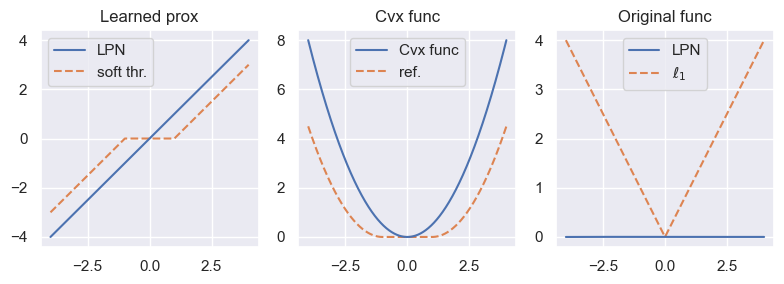

In [14]:
gamma_loss = 0.4
for g in optimizer.param_groups:
    g["lr"] = 1e-4

for i in range(4000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)

gamma=0.3

iteration 0 loss 2.380353180342354e-05
iteration 500 loss 4.2697192839113995e-06
iteration 1000 loss 7.408201781800017e-06
iteration 1500 loss 0.00012322276597842574
iteration 2000 loss 2.6665507903089747e-05
iteration 2500 loss 1.9673258066177368e-05
iteration 3000 loss 1.5495448678848334e-05
iteration 3500 loss 5.0557704525999725e-05
mse 5.344010829925537
mse 2.419473886489868
mse 1.0292561054229736
mse 0.40437817573547363
mse 0.1448523849248886
mse 0.046992041170597076
mse 0.013729301281273365
mse 0.0035728481598198414
mse 0.0008241936448030174
mse 0.0001681175926933065
final mse 3.076596112805419e-05
(1000,) (1000,) (1000,) (1000,)


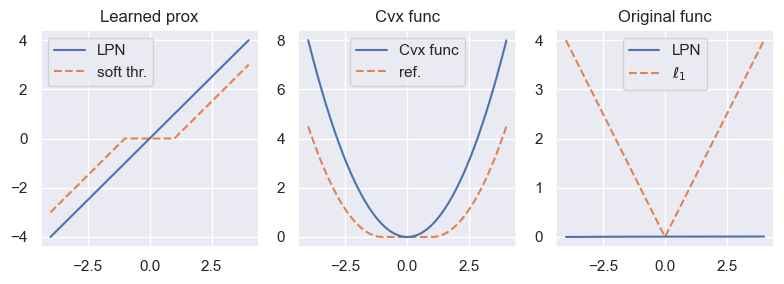

In [15]:
gamma_loss = 0.3
for g in optimizer.param_groups:
    g["lr"] = 1e-4

for i in range(4000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)

gamma=0.2

iteration 0 loss 3.298020237707533e-05
iteration 500 loss 2.3476779915654333e-06
iteration 1000 loss 6.263137038331479e-06
iteration 1500 loss 7.429569905070821e-06
iteration 2000 loss 2.3455322661902755e-06
iteration 2500 loss 5.618453087663511e-06
iteration 3000 loss 2.7113853775517782e-06
iteration 3500 loss 4.570335022435756e-06
mse 5.344010829925537
mse 2.420485019683838
mse 1.0297272205352783
mse 0.40527185797691345
mse 0.14548447728157043
mse 0.047118160873651505
mse 0.013705961406230927
mse 0.003550642868503928
mse 0.0008157743141055107
mse 0.00016581465024501085
final mse 3.0252122087404132e-05
(1000,) (1000,) (1000,) (1000,)


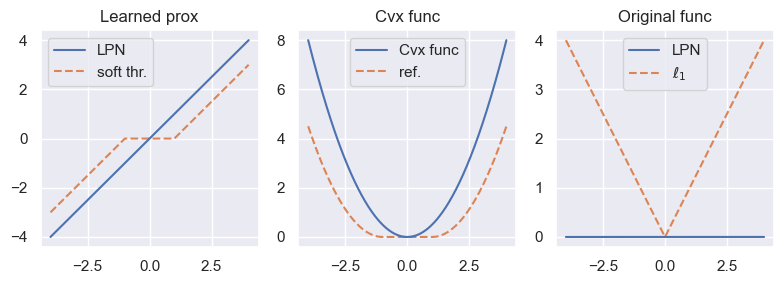

In [16]:
gamma_loss = 0.2
for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(4000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)

gamma=0.1

iteration 0 loss 1.3594508345704526e-05
iteration 500 loss 1.3024508916714694e-05
iteration 1000 loss 0.0005094765219837427
iteration 1500 loss 1.656949461903423e-05
iteration 2000 loss 1.700624852674082e-05
iteration 2500 loss 9.041219527716748e-06
iteration 3000 loss 5.149692242412129e-06
iteration 3500 loss 1.0331660632800777e-05
iteration 0 loss 1.0207474588241894e-05
iteration 500 loss 1.0681331332307309e-05
iteration 1000 loss 7.288306733244099e-06
iteration 1500 loss 1.0322571142751258e-05
iteration 2000 loss 5.617600618279539e-05
iteration 2500 loss 3.2811523851705715e-05
iteration 3000 loss 7.4928107096639e-06
iteration 3500 loss 5.9687795328500215e-06
mse 5.344010829925537
mse 2.42049241065979
mse 1.029662847518921
mse 0.40519264340400696
mse 0.14539867639541626
mse 0.047098319977521896
mse 0.013715306296944618
mse 0.003558534663170576
mse 0.000819192617200315
mse 0.00016668027092237025
final mse 3.0393703127629124e-05
(1000,) (1000,) (1000,) (1000,)


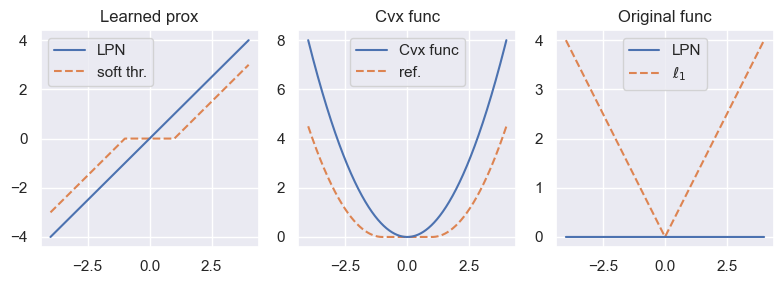

In [17]:
gamma_loss = 0.1
for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(4000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

for g in optimizer.param_groups:
    g["lr"] = 1e-6

for i in range(4000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)